# Transfer learning with PyTorch on a custom dataset

Learning how to perform transfer learning on a dataset that is not preprocessed and bundled as part of torch/tensorflow or any other deep learning framework. 

- GOAL: I want to build an image classfier, using the resnet model (should be possible to easily be substituted with any other achitecture), and retrain the last FC layer with processed images from the custom dataset. 
- DATASET: The dog breed identification dataset from Kaggle (https://www.kaggle.com/c/dog-breed-identification/data)

### Preprocessing the dataset

The structure of the dataset was originally meant for a kaggle competition. Improvising on what is available, I just picked the train.zip and labels.csv.zip folder, to create a supervised learning problem for the Image classifier to solve. 

PS: I had access to a machine with an NVIDIA TITAN X GPU. It made my life easier. It would take a significant amount of time if this were to be performed on a machine with no GPU.

In [1]:
# All essential imports

import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

%matplotlib inline
import pandas as pd
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import cv2
import os
from __future__ import division

!set "KERAS_BACKEND=tensorflow"
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
from multiprocessing import cpu_count
print("cpu_count: ", cpu_count())
# !pip install psutil
import psutil
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

%matplotlib inline
import time
import datetime as dt

from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image

from sklearn import preprocessing

np.random.seed(0)

('__Python VERSION:', '2.7.6 (default, Oct 26 2016, 20:30:19) \n[GCC 4.8.4]')
('__pyTorch VERSION:', '0.2.0_3')
__CUDA VERSION
('__CUDNN VERSION:', 6021)
('__Number CUDA Devices:', 0)
__Devices
('OS: ', 'linux2')
('Python: ', '2.7.6 (default, Oct 26 2016, 20:30:19) \n[GCC 4.8.4]')
('PyTorch: ', '0.2.0_3')
('Numpy: ', '1.13.1')
('cpu_count: ', 8)
2.7.6 (default, Oct 26 2016, 20:30:19) 
[GCC 4.8.4]
0.0
svmem(total=33647104000, available=29258309632, percent=13.0, used=4153077760, free=14064795648, active=9064607744, inactive=8636870656, buffers=1390895104, cached=14038335488, shared=147791872)
('memory GB:', 0.17316436767578125)


In [2]:
# Configuring the Torch framework to use the GPU

use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [3]:
# These correspond to images and labels in the train folder (id.jpg)
breeds = pd.read_csv('data/labels.csv.zip')
data_dir = 'data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))

In [4]:
# Using SKLearn's label encoder to encode the different breed labels (Strings) to Integers
le = preprocessing.LabelEncoder()
labels['class'] = le.fit_transform(labels['breed'])

# Creating a copy of the dataframe to identify labels at a later stage
labels_copy = pd.DataFrame.copy(labels)

labels_cleaned = labels.drop('breed', 1)

In [5]:
# Helper method to retieve the breed name from the encoded label
def getBreedByClass(classvar):
    return labels_copy.loc[labels_copy['class'] == classvar, 'breed'].values[0]

In [6]:
# Stratified split
'''
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(labels_cleaned, labels_cleaned['class'])

# print sss

for train_index, test_index in sss.split(labels_cleaned, labels_cleaned['class']):
    print("TRAIN:", train_index, "TEST:", test_index)
    labels_train, labels_test = labels_cleaned[train_index], labels_cleaned[test_index]
'''    
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    labels_cleaned, 
    labels_cleaned['class'], 
    test_size=0.20, 
    stratify = labels_cleaned['class'],
    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, 
    y_trainval, 
    test_size=0.125, 
    stratify = y_trainval,
    random_state=42)

In [7]:
'''
# Split the dataset into train, validate and test in the ratio 7:1:2
train_valid = labels_cleaned.sample(frac=0.8)
test = labels_cleaned[~labels_cleaned['id'].isin(train_valid['id'])]

train = train_valid.sample(frac=0.875)
valid = train_valid[~train_valid['id'].isin(train['id'])]
'''
print(X_train.shape, X_val.shape, X_test.shape)

((7154, 2), (1023, 2), (2045, 2))


In [8]:
# A custom dataset class
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('int')
        if self.transform:
            image = self.transform(image)
        return [image, labels[0]]

In [9]:
# Preprocessing the input images
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

In [10]:
# Creating the dataset and dataloaders

train_ds = DogsDataset(X_train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(X_val, data_dir+'train/', transform=ds_trans)
test_ds = DogsDataset(X_test, data_dir+'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=True, num_workers=4)

In [11]:
# Helper method to show an image after denormalization
def imshow(axis, inp, label):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [12]:
# Testing the dataloader and help method
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    ax.text(10, 210, '{}'.format(labels.loc[labels['class'] == label[i], 'breed'].values[0]), color='k', backgroundcolor='w', alpha=0.8)
    imshow(ax, img[i], label[i])


(torch.Size([4, 3, 224, 224]), torch.Size([4]))


In [13]:
# Configuring the torch model directory (where we save the imagenet trained model)
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)


In [14]:
# Make sure we curl and download the appropriate model
use_gpu = torch.cuda.is_available()
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

# The model seems to work OK if the Resnet outputs probabilities for the imagenet's 1000 labels

torch.Size([4, 1000])

In [15]:

# Replace last layer and train
all_losses = []
all_accuracy = []

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
        
        all_losses.append(train_epoch_loss)
        all_accuracy.append(train_epoch_acc)
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [16]:

resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 120 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 120)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}


In [17]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
start_time = time.time()
#print('Started training at: {}'.format(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))))
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
#print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))


Epoch [0/9] train loss: 0.8277 acc: 0.2733 valid loss: 0.3094 acc: 0.6716
Epoch [1/9] train loss: 0.4520 acc: 0.5647 valid loss: 0.2024 acc: 0.7703
Epoch [2/9] train loss: 0.3571 acc: 0.6339 valid loss: 0.1715 acc: 0.7830
Epoch [3/9] train loss: 0.3071 acc: 0.6746 valid loss: 0.1722 acc: 0.7810
Epoch [4/9] train loss: 0.2830 acc: 0.6972 valid loss: 0.1531 acc: 0.7977
Epoch [5/9] train loss: 0.2664 acc: 0.7119 valid loss: 0.1619 acc: 0.7928
Epoch [6/9] train loss: 0.2552 acc: 0.7141 valid loss: 0.1725 acc: 0.7986
Epoch [7/9] train loss: 0.2145 acc: 0.7744 valid loss: 0.1543 acc: 0.8104
Epoch [8/9] train loss: 0.2113 acc: 0.7773 valid loss: 0.1536 acc: 0.8162
Epoch [9/9] train loss: 0.2114 acc: 0.7797 valid loss: 0.1483 acc: 0.8162
Best val Acc: 0.816227


In [18]:
# Plotting the accuracy and loss over time
f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
axarr[0].plot(all_accuracy)
axarr[0].set_title('Accuracy')
axarr[1].plot(all_losses)
axarr[1].set_title('Loss')

plt.show()


In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    use_gpu = torch.cuda.is_available()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        if use_gpu:
            input_var = torch.autograd.Variable(input.cuda(), volatile=True)
            target_var = torch.autograd.Variable(target.cuda(), volatile=True)
        else:
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        #if i % args.print_freq == 0:
        if True:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [ ]:
validate(valid_dl, model, criterion)

In [28]:
# Helper method to visualize the dataset sets 
def visualize_model(dataloader, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloader):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j], labels.data[j])
            ax.text(10, 210, 'P:{}/GT:{}'.format( # P: Prediction , GT: Ground Truth
                labels_copy.loc[labels_copy['class'] == preds[j], 'breed'].values[0], 
                labels_copy.loc[labels_copy['class'] == labels.data[j], 'breed'].values[0]), 
                color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

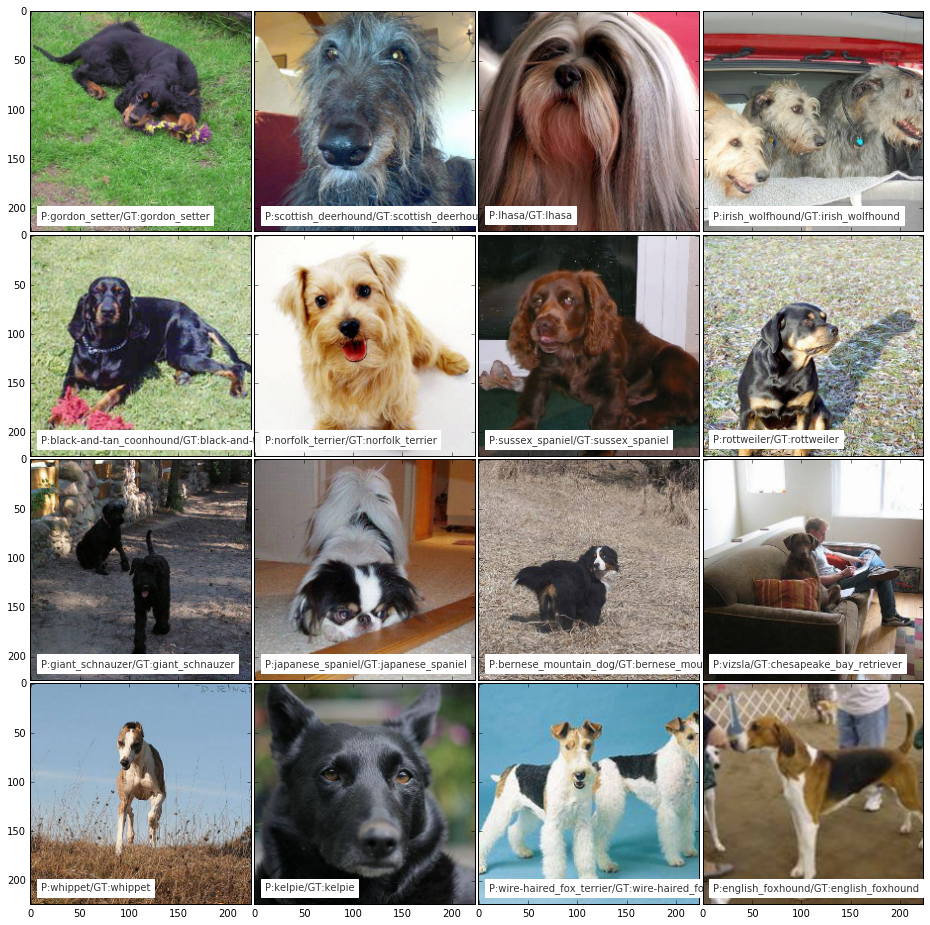

In [29]:
visualize_model(test_dl, resnet)